In this notebook, we explore the maximum wind speed the UAV can counteract at different max velocities.

In [46]:
from systems.long_multirotor21d import LongTrajEnv

from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from systems.multirotor21d import MultirotorTrajEnv, VP
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_pidcontroller import (
    get_controller, make_disturbance_fn,
    apply_params as apply_params_pid, get_study as get_study_pid
)
from scripts.opt_multirotorenv import apply_params, get_study, get_established_controller

In [47]:
def get_env(wind_ranges, speed=7, scurve=False, **kwargs):  
    kw = dict(
        safety_radius=5,
        vp=VP,get_controller_fn=lambda m: get_established_controller(m, speed),
        steps_u=50, # RL parameter, does not matter here
        scaling_factor=0.5, # same as above
        wind_ranges=wind_ranges,
        proximity=5,
        seed=0)
    return MultirotorTrajEnv(**kw)

In [48]:
# runs trajectory with a wind range in the same format as other files:
# [(xmin,xmax), (ymin,ymax), (zmin,zmax)]
def run_trajectory(wind_ranges: np.ndarray, initial_waypts: np.ndarray, waypts: np.ndarray, speed=7): 
    env = LongTrajEnv(
        waypoints = waypts,
        base_env = get_env(wind_ranges, speed=speed),
        initial_waypoints = initial_waypts,
        random_cardinal_wind=False
    )
    done = False
    env.reset()
    env.base_env.period=1000
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        state, reward, done, info = env.step([0,-1,0]) # trajectory full south
        log.log(reward=reward)

    log.done_logging()
    return log, info

In [49]:
# The UAV can compensate for that wind at its speed if it progresses towards the negative direction
def can_compensate(log):
    return log.y[-1] < 0

In [59]:
winds = [7,8,9,10,11,12,13,14,15]
possible_speeds = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

In [60]:
south_np = np.array([[0,-1000,0]])
south_traj = Trajectory(None, points=south_np, resolution=10000)
south_wpts = south_traj.generate_trajectory(curr_pos=np.array([0,0,0]))

In [62]:
min_speeds = []
for wind in tqdm(winds):
    wind_range = [(0,0),(wind,wind),(0,0)]

    prev_speed = possible_speeds[0]
    for speed in possible_speeds:
        log, info = run_trajectory(wind_ranges=wind_range, initial_waypts=south_np, waypts=south_wpts, speed=speed)
        if not can_compensate(log):
            min_speeds.append([wind, prev_speed])
            break
        prev_speed = speed

  0%|          | 0/9 [00:00<?, ?it/s]

In [71]:
log, info = run_trajectory(wind_ranges=[(0,0),(11,11),(0,0)], initial_waypts=south_np, waypts=south_wpts, speed=15)

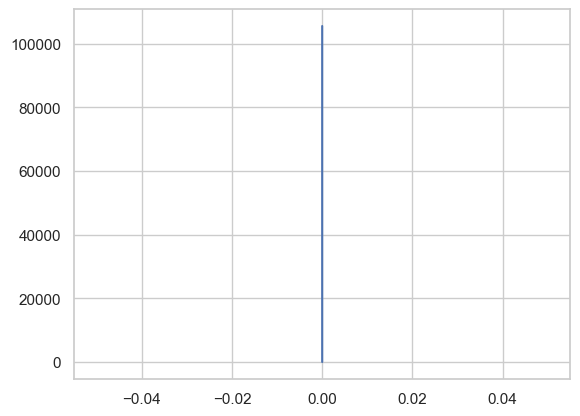

In [72]:
plt.plot(log.x, log.y)

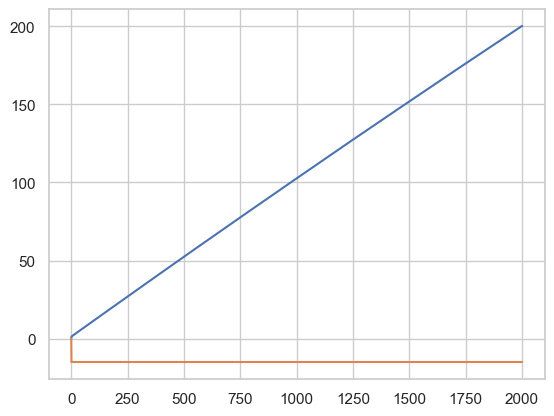

In [73]:
plt.plot(log.velocity[:,1])
plt.plot(log.target.velocity[:,1])

In [63]:
min_speeds

[[7, 2],
 [8, 2],
 [9, 3],
 [10, 3],
 [11, 15],
 [12, 15],
 [13, 15],
 [14, 15],
 [15, 15]]

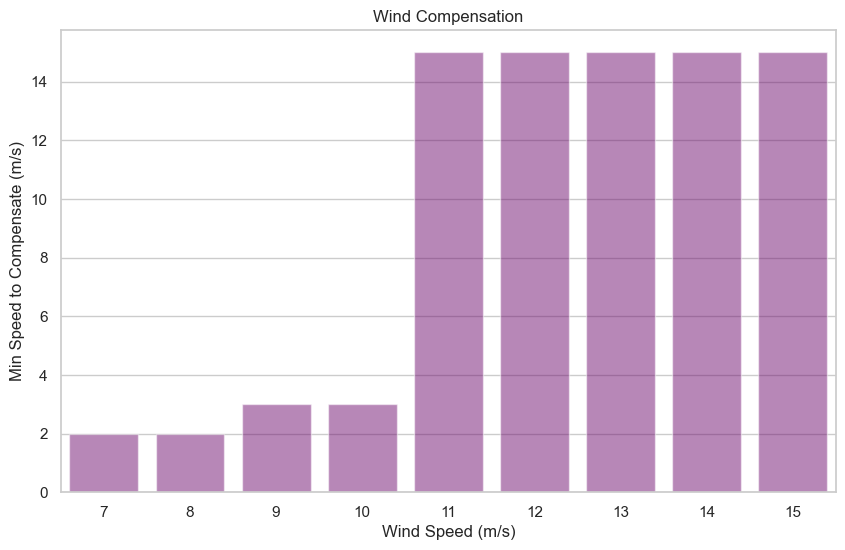

In [78]:
df = pd.DataFrame(min_speeds, columns=['Wind Speed', 'Vehicle Speed'])
df.to_csv('./data/min_spees.csv')

# Create the bar plot using Seaborn
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the bar plot
plot = sns.barplot(x='Wind Speed', y='Vehicle Speed', data=df, color='purple', alpha=0.5)

# Set labels and title
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Min Speed to Compensate (m/s)')
plt.title('Wind Compensation')

# Show the plot
plt.show()

In [82]:
import numpy as np

def calculate_intermediate_point(point, reference_point, distance=5):
    # Convert points to numpy arrays for vector calculations
    point = np.array(point)
    reference_point = np.array(reference_point)
    
    # Calculate the vector from the point to the reference point
    vector_to_reference = reference_point - point
    
    # Calculate the distance between the point and the reference point
    distance_to_reference = np.linalg.norm(vector_to_reference)
    
    if distance_to_reference <= distance:
        # If the distance is within the specified range, return the reference point
        return reference_point
    else:
        # Calculate the intermediate point that is 'distance' units along the vector_to_reference
        intermediate_point = point + (distance / distance_to_reference) * vector_to_reference
        return intermediate_point

# Example usage
point = [100, 0, 0]
reference_point = [100, 100, 0]
intermediate = calculate_intermediate_point(point, reference_point, 0)

print("Intermediate point:", intermediate)


Intermediate point: [100.   0.   0.]
